In [1]:
import json
import logging
import logging.handlers
import os
from functools import partial
from typing import Any

import dill
import matplotlib
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import ml_collections
import numpy as np
import tree
import yaml
from matplotlib import cm
from matplotlib.collections import PolyCollection
from matplotlib.colors import LightSource, ListedColormap
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mpl_toolkits.mplot3d import art3d, axes3d


# plt.style.use("_mpl-gallery-nogrid")

In [2]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target) ** 2) / np.mean(target**2))


def get_normalization_ratio(psi_range, boundary_range):
    psi_range = float(psi_range.split(" ")[-1])
    boundary_range = float(boundary_range.split(" ")[-1])
    return psi_range / boundary_range


def plot_contour(
    X,
    Y,
    phi,
    title,
    colorbar_offset=None,
    fontdict=None,
    save_path=None,
    figsize=(6, 5),  # 修改为更合适的默认大小
    cmap="coolwarm",
):
    def _plt_contour(ax, X, Y, Z, cmap="coolwarm", levels=40):
        ax.tick_params(axis="x", labelsize=26, pad=2, direction="in")
        ax.tick_params(axis="y", labelsize=26, pad=2, direction="in")
        font = {"size": 26, "weight": "normal"}

        xticks = np.linspace(0, 1, 5)
        ax.set_xticks(xticks)

        new_xlabels = [f"{x:.2f}" if i % 2 == 1 else "" for i, x in enumerate(xticks)]
        ax.set_xticklabels(new_xlabels)

        ax.set_xlabel("x", labelpad=5, rotation=0, fontdict=font)
        ax.set_ylabel("y", labelpad=0, rotation=0, fontdict=font, y=0.45)

        cs = ax.contourf(X, Y, Z, cmap=cmap, levels=levels)
        return cs

    def scientific_format(x, pos, colorbar_length=None):
        """
        格式化科学计数法：只显示基数，指数部分将在colorbar顶部显示
        """
        if x == 0 or abs(x) < 1e-15:
            return "0.0"

        try:
            base = "{:.1f}".format(x / 10 ** np.floor(np.log10(abs(x))))
            # 每隔两个刻度显示一个数字
            if pos % 2 == 0:
                return base
            else:
                return ""
        except (ValueError, RuntimeWarning):
            return "0.0"

    # 设置全局参数
    plt.rcParams["figure.dpi"] = 300
    plt.rcParams["savefig.dpi"] = 300

    # 创建固定大小的图形
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # 设置固定的边距
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.95)

    cs1 = _plt_contour(ax, X, Y, phi, cmap=cmap, levels=40)
    ax.set_title(title, **fontdict)

    # 使用 make_axes_locatable 创建 colorbar
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)

    # 创建 colorbar
    cbar = fig.colorbar(cs1, cax=cax)
    cbar.ax.tick_params(labelsize=26)

    # 获取colorbar的刻度数量
    if colorbar_offset is not None:
        cbar.locator = MultipleLocator(colorbar_offset)
        cbar.update_ticks()
    colorbar_ticks = len(cbar.get_ticks())

    # 使用partial固定colorbar_length参数
    formatter = FuncFormatter(
        partial(scientific_format, colorbar_length=colorbar_ticks)
    )
    cbar.ax.yaxis.set_major_formatter(formatter)

    # 添加指数标注
    vmax = np.max(np.abs(phi))
    exponent = int(np.floor(np.log10(vmax)))
    cbar.ax.text(
        x=2,  # x位置（相对于colorbar宽度的比例）
        y=1.02,  # y位置（相对于colorbar高度的比例）
        s=f"$\\times10^{{{exponent}}}$",
        ha="center",
        va="bottom",
        transform=cbar.ax.transAxes,
        fontsize=22,
    )

    if save_path is not None:
        fig.set_size_inches(figsize)
        plt.savefig(
            save_path, dpi=300, bbox_inches="tight", pad_inches=0.1, format="pdf"
        )
        plt.close(fig)

In [3]:
# result_path = "/nfs/my/projects/deeprte/results/2023-06-15T16:21:40"
# item_path = "/workspaces/deeprte/data/results/bc1-g0.1/example_1"
# item_path = "/workspaces/deeprte/data/results/g0.1/example_2"
# item_path = "/workspaces/deeprte/data/results/g0.5/example_0"
# item_path = "/workspaces/deeprte/data/results/g0.8/example_0"
# item_path = (
#     "/workspaces/deeprte/data/results/sin-g0.1-amplitude5-wavenumber10/example_1"
# )
item_path = (
    "/workspaces/deeprte/data/results/sin-rv-g0.1-amplitude5-wavenumber10/example_1"
)
file_path = os.path.join(item_path, "result.dill")

In [4]:
# plot contour params
n = 40
h = 1 / n
X, Y = np.meshgrid(
    np.linspace(0 + 0.5 * h, 1 - 0.5 * h, n),
    np.linspace(0 + 0.5 * h, 1 - 0.5 * h, n),
    indexing="ij",
)

In [5]:
with open(file_path, "rb") as f:
    result = dill.load(f)

# Plot phi
phi_pre = np.squeeze(result["predicted_phi"])
phi_label = np.squeeze(result["phi_label"])

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize, PowerNorm
from matplotlib.ticker import MultipleLocator


def plot_phi(
    X,
    Y,
    Z,
    save_path=None,
    cmap="RdYlBu_r",
    norm=PowerNorm(1.2),
    levels=25,
    figsize=(6, 6),
):
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={"projection": "3d"})

    # 设置网格线属性
    ax.xaxis._axinfo["grid"].update({"linewidth": 0.3, "linestyle": "-.", "color": "k"})
    ax.yaxis._axinfo["grid"].update({"linewidth": 0.3, "linestyle": "-.", "color": "k"})
    ax.zaxis._axinfo["grid"].update({"linewidth": 0.3, "linestyle": "-.", "color": "k"})

    # 设置网格背景色
    ax.xaxis.set_pane_color((0, 0, 0, 0))
    ax.yaxis.set_pane_color((0, 0, 0, 0))
    ax.zaxis.set_pane_color((0, 0, 0, 0))

    ax.zaxis._axinfo["juggled"] = (1, 2, 7)

    ax.xaxis._axinfo["tick"]["outward_factor"] = 0
    ax.xaxis._axinfo["tick"]["inward_factor"] = 0.4
    ax.yaxis._axinfo["tick"]["outward_factor"] = 0
    ax.yaxis._axinfo["tick"]["inward_factor"] = 0.4
    ax.zaxis._axinfo["tick"]["outward_factor"] = 0.4
    ax.zaxis._axinfo["tick"]["inward_factor"] = 0.0

    # 设置刻度间隔
    # x0 = MultipleLocator(0.25)  # x轴每0.25一个刻度
    # y0 = MultipleLocator(0.25)
    z0 = MultipleLocator(2.5)

    # ax.xaxis.set_major_locator(x0)
    # ax.yaxis.set_major_locator(y0)
    ax.zaxis.set_major_locator(z0)

    ax.tick_params(
        axis="z",
        labelsize=18,
        pad=0,
        direction="in",
        width=0.1,
    )
    ax.tick_params(
        axis="x",
        labelsize=18,
        pad=-5,
        direction="in",
        width=2,
    )
    ax.tick_params(
        axis="y",
        labelsize=18,
        pad=2,
        direction="in",
        width=0.5,
    )

    # 增大字体大小
    font = {"size": 26}
    ax.set_xlabel("x", labelpad=-5, rotation=0, fontdict=font)
    ax.set_ylabel("y", labelpad=5, rotation=0, fontdict=font)
    ax.set_zlabel(
        r"$\Phi(\mathbf{r})$",
        labelpad=10,
        rotation=90,
        fontdict=font,
    )

    # 绘制3D表面
    surf = ax.plot_surface(
        X,
        Y,
        Z,
        cmap=cmap,
        rstride=1,
        cstride=1,
        linewidth=0.2,
        alpha=1,
        lw=0.5,
        norm=norm,
    )

    z_min, z_max = np.min(Z), np.max(Z)
    z_range = z_max - z_min
    offset = z_min - 0.2 * z_range
    ax.contour(
        X,
        Y,
        Z,
        zdir="z",
        offset=offset,
        cmap=cmap,
        norm=norm,
        levels=levels,
        linewidths=0.8,
        antialiased=False,
    )

    ax.set(zlim=(offset, z_max))

    ax.view_init(elev=17, azim=295)

    # 获取当前刻度并设置标签
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    # zticks = ax.get_zticks()

    # 只保留首尾标签
    new_xlabels = [f"{x:.2f}" if i % 2 == 0 else "" for i, x in enumerate(xticks)]
    new_ylabels = [f"{y:.2f}" if i % 2 == 0 else "" for i, y in enumerate(yticks)]
    # new_zlabels = [f"{z:.1f}" if i % 2 == 1 else "" for i, z in enumerate(zticks)]

    ax.set_xticklabels(new_xlabels)
    ax.set_yticklabels(new_ylabels)

    if save_path is not None:
        plt.savefig(save_path)

In [11]:
import numpy as np
from scipy import interpolate


def interpolate_data(phi_label, n):
    # 创建原始的x和y坐标
    x = np.linspace(0, 1, phi_label.shape[1])
    y = np.linspace(0, 1, phi_label.shape[0])

    # 创建插值函数
    f = interpolate.RegularGridInterpolator((x, y), phi_label)

    h = 1 / n
    X, Y = np.meshgrid(
        np.linspace(0 + 0.5 * h, 1 - 0.5 * h, n),
        np.linspace(0 + 0.5 * h, 1 - 0.5 * h, n),
        indexing="ij",
    )

    data = np.stack((X, Y), axis=-1)
    # 使用插值函数计算新的数据
    data_new = f(data)

    return X, Y, data_new

/tmp/ipykernel_95859/1156320140.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xlabels)
/tmp/ipykernel_95859/1156320140.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_ylabels)


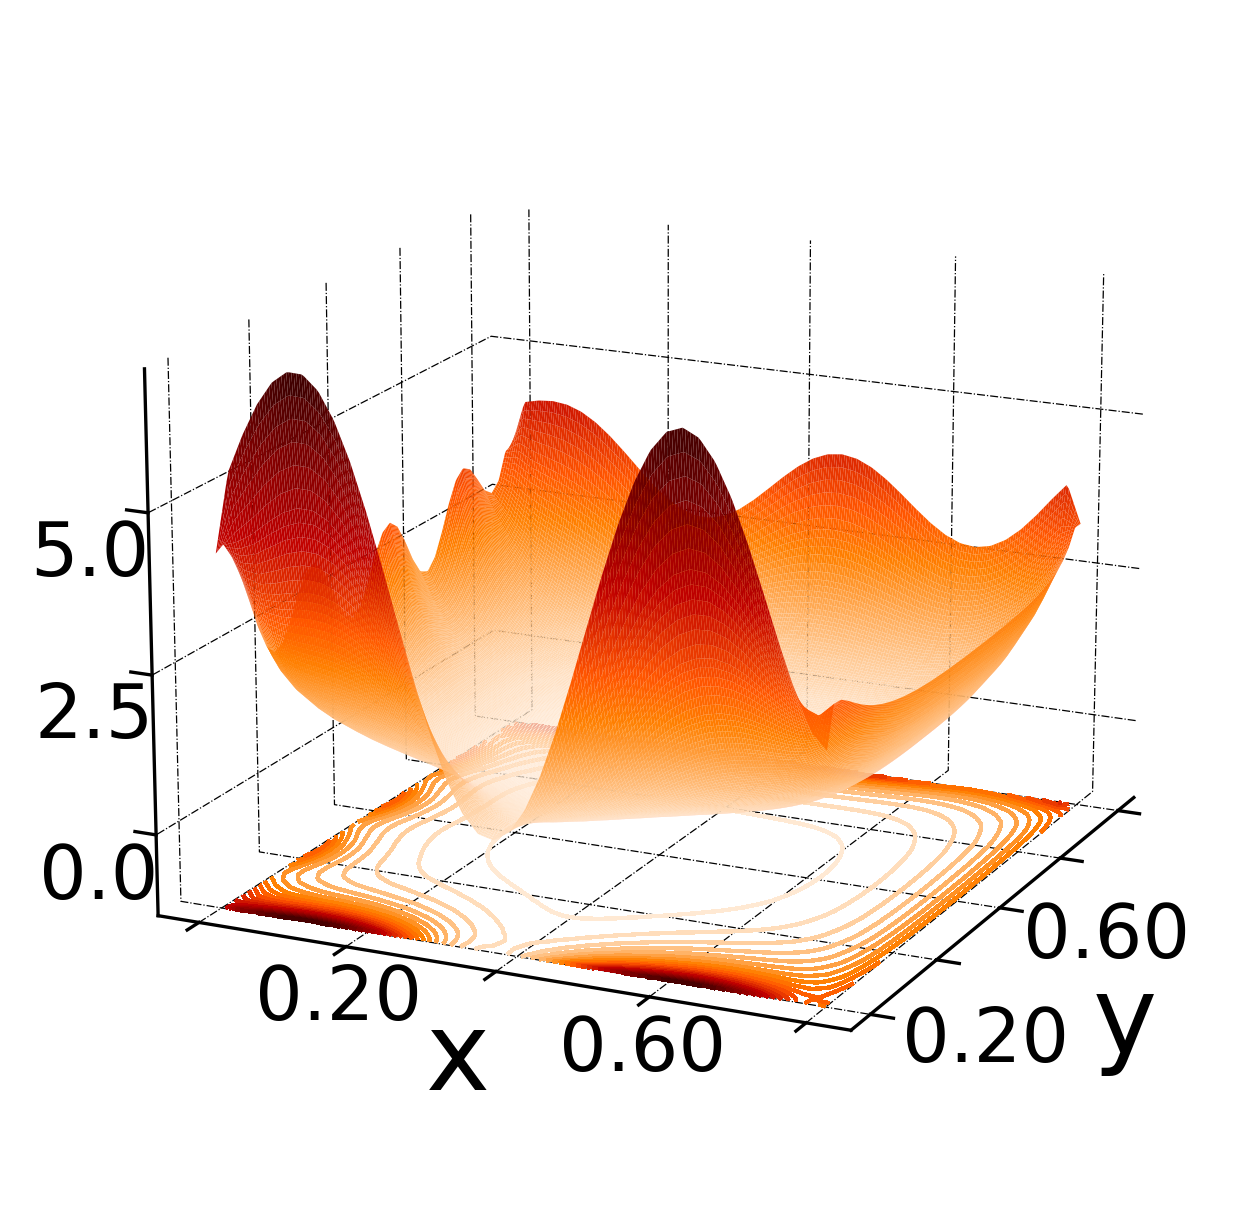

In [12]:
X, Y, label_int = interpolate_data(phi_label, 240)
_, _, pre_int = interpolate_data(phi_pre, 240)

# from matplotlib.colors import LinearSegmentedColormap

# colors = [
#     (191 / 256, 216 / 256, 237 / 256),
#     (8 / 256, 66 / 256, 133 / 256),
# ]  # R -> G -> B
# n_bin = 100  # Discretizes the interpolation into bins
# cmap_name = "my_list"
# cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

cmap = matplotlib.colormaps["gist_heat_r"]
cmap = cmap(np.linspace(0.03, 0.85, 256))
cmap = ListedColormap(cmap)

plot_phi(
    X,
    Y,
    label_int,
    cmap=cmap,
    figsize=(6, 5),
    save_path=os.path.join(item_path, "phi_label_3d.pdf"),
)

In [9]:
cmap = matplotlib.colormaps["gist_heat_r"]
cmap = cmap(np.linspace(0, 0.85, 256))
cmap = ListedColormap(cmap)
fontdict = {"fontsize": 50, "fontweight": "normal"}

plot_contour(
    X,
    Y,
    label_int,
    # colorbar_offset=1.5,
    title=r"",
    figsize=(6, 5),
    fontdict=fontdict,
    save_path=os.path.join(item_path, "phi_label.pdf"),
    cmap=cmap,
)

plot_contour(
    X,
    Y,
    pre_int,
    # colorbar_offset=1.5,
    title=r"",
    figsize=(6, 5),
    fontdict=fontdict,
    save_path=os.path.join(item_path, "phi_pre.pdf"),
    cmap=cmap,
)

plot_contour(
    X,
    Y,
    abs(pre_int - label_int),
    # colorbar_offset=0.05,
    title=r"",
    figsize=(6, 5),
    fontdict=fontdict,
    save_path=os.path.join(item_path, "phi_error.pdf"),
    cmap=cmap,
)